## Contents
-  [1.Importing Libraries](#1)
-  [2.Dataset Management](#2)
    -  [2.1.Downloading and Extracting Dataset](#2.1)
    -  [2.2.Visualizing Dataset](#2.2)
    -  [2.3.Splitting Dataset](#2.3)
    -  [2.4.Pytorch DataLoaders](#2.4)
-  [3.Initializing pre-trained model](#3)
-  [4.Training](#4)
-  [5.Plotting Results](#5)
    -  [5.1.Plotting Loss vs MiniBatch](#5.1)
    -  [5.2.Plotting Accuracy vs MiniBatch](#5.2)
    -  [5.3.Plotting Loss vs Epoch](#5.3)
    -  [5.4.Plotting Accuracy vs Epoch](#5.4)
    -  [5.5.Plotting F1 Score vs Epoch](#5.5)
    -  [5.6.Plotting Recall vs Epoch](#5.6)
    -  [5.7.Plotting Precision vs Epoch](#5.7)
    -  [5.8.Plotting Kappa vs Epoch](#5.8)
-  [6.Testing](#6)

### 1.Importing Libraries <a class="anchor" id="1"></a>

In [1]:
!pip install timm
import timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 839.3 kB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
from torchvision import models
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.data import Dataset as Dataset
from torch.utils.data import DataLoader as DataLoader
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from PIL import Image
import os
import random
from PIL import Image

import gc



torch.cuda.empty_cache()
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

sns.set_style("darkgrid")
plt.rcParams["figure.figsize"] = (10,10)


### 2.Dataset Managament <a class="anchor" id="2"></a>

#### 1.Downloading and Extracting Dataset <a class="anchor" id="2.1"></a>

In [3]:
import pandas as pd

test_raw = pd.read_csv("/kaggle/input/game-of-deep-learning-ship-datasets/test_ApKoW4T.csv")
train_raw = pd.read_csv("/kaggle/input/game-of-deep-learning-ship-datasets/train/train.csv")
train_raw.head()



,image,category
0,2823080.jpg,1
1,2870024.jpg,1
2,2662125.jpg,2
3,2900420.jpg,3
4,2804883.jpg,2


In [4]:
path = '/kaggle/input/game-of-deep-learning-ship-datasets/train/images/'

test_img = []

img = []
label = []

for index, row in train_raw.iterrows():
    img.append(path+row['image'])
    label.append(row['category']-1)
    
for index, row in test_raw.iterrows():
    test_img.append(path+row['image'])

#### 2.Visualizing Dataset <a class="anchor" id="2.2"></a>

In [5]:
print(len(test_img), len(img))

2680 6252


In [6]:
from collections import Counter
Counter(label)

Counter({0: 2120, 1: 1167, 2: 916, 3: 832, 4: 1217})

#### 3.Splitting Dataset <a class="anchor" id="2.3"></a>

In [7]:
x = [0, 0, 0, 0, 0]
i=0

val_img = []
val_label = []

while (x!=[15, 15, 15, 15, 15]):
    l = label[i]
    if x[l]!=15:
        val_img.append(img[i])
        val_label.append(l)
        del label[i], img[i]
        x[l]+=1
        continue
        
    i+=1        

In [8]:
Counter(val_label)

Counter({0: 15, 1: 15, 2: 15, 3: 15, 4: 15})

#### 4.Pytorch DataLoaders <a class="anchor" id="2.4"></a>

In [9]:
class Dataset(Dataset):
    def __init__(self,x,y,transform = 'T.Resize((224,224))'):
        self.transform = transform
        self.x = x
        self.y = y 
        self.len = len(x)
   
    def __len__(self):
        return self.len
    
    def __getitem__(self,i):
        img = Image.open(self.x[i]).convert('RGB')
        return torch.FloatTensor(np.asarray(self.transform(img))),torch.LongTensor([self.y[i]])

class TestDataset(Dataset):
    def __init__(self,x,transform = 'T.Resize((224,224))'):
        self.transform = transform
        self.x = x
        self.len = len(x)
   
    def __len__(self):
        return self.len
    
    def __getitem__(self,i):
        img = Image.open(self.x[i]).convert('RGB')
        return torch.FloatTensor(np.asarray(self.transform(img)))
    

batch_size = 16

transforms_train = T.Compose([
        T.Resize((224,224)),
#         T.RandomRotation(degrees=(-45, 45)),
#         T.RandomHorizontalFlip(),
#         T.RandomVerticalFlip(),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

transforms_test = T.Compose([
        T.Resize((224,224)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

train_dataset = Dataset(img, label,transform =transforms_train)
validation_dataset = Dataset(val_img, val_label,transform =transforms_test)
test_dataset = TestDataset(test_img,transform =transforms_test)

train_dataloader = DataLoader(train_dataset , batch_size = batch_size , shuffle = True )
validation_dataloader = DataLoader(validation_dataset , batch_size = batch_size , shuffle = True )
test_dataloader = DataLoader(test_dataset , batch_size = batch_size , shuffle = False )

In [10]:
next(iter(test_dataloader))

tensor([[[[ 2.1290,  2.1290,  2.0777,  ...,  1.7009,  1.5125,  1.6153],
          [ 2.1290,  2.1290,  2.0777,  ...,  1.7009,  1.5125,  1.6153],
          [ 2.1119,  2.1119,  2.0948,  ...,  1.5810,  1.4954,  1.6153],
          ...,
          [-0.0972, -0.2856, -0.3369,  ..., -0.6965, -0.4054, -0.0116],
          [-0.0116, -0.1999, -0.2856,  ..., -0.5767, -0.2342,  0.1083],
          [-0.0116, -0.1999, -0.2856,  ..., -0.5767, -0.2342,  0.1083]],

         [[ 2.2710,  2.2710,  2.2535,  ...,  1.9209,  1.7633,  1.8683],
          [ 2.2710,  2.2710,  2.2535,  ...,  1.9209,  1.7633,  1.8683],
          [ 2.2535,  2.2710,  2.2710,  ...,  1.8158,  1.7458,  1.8683],
          ...,
          [-0.1975, -0.3550, -0.4076,  ..., -0.7227, -0.5126, -0.1275],
          [-0.1099, -0.2675, -0.3550,  ..., -0.6176, -0.3550, -0.0224],
          [-0.1099, -0.2675, -0.3550,  ..., -0.6176, -0.3550, -0.0224]],

         [[ 2.5354,  2.5354,  2.4831,  ...,  2.2566,  2.0300,  2.1346],
          [ 2.5354,  2.5354,  

### 3.Initializing pre-trained model <a class="anchor" id="3"></a>

In [11]:
model = models.resnet50(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 5)
for param in model.parameters():
    param.requires_grad = True

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

### 4.Training <a class="anchor" id="4"></a>

In [12]:
lr = 0.0015
epoch = 45
train_dataset_size = train_dataset.__len__()
validation_dataset_size = validation_dataset.__len__()
train_n_minibatches = train_dataloader.__len__()
validation_n_minibatches = validation_dataloader.__len__()

device = 'cuda'
model.to(device)
loss_history = [[],[]] #[[train], [validation]]
accuracy_history = [[],[]] #[[train], [validation]]
# prec_history = [[],[]] #[[train], [validation]]
# recall_history = [[],[]] #[[train], [validation]]
# f1_history = [[],[]] #[[train], [validation]]
# support_history = [[],[]] #[[train], [validation]]

results = [[],[]]
kappa = [[],[]]

criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.SGD(model.parameters(),lr = lr)



In [13]:
from sklearn.metrics import precision_recall_fscore_support, cohen_kappa_score


for e in range(epoch):
    print(f'---------------------------------------EPOCH {e+1}-------------------------------------------')
    y_all_train_true = []
    y_all_train_pred = []
    y_all_val_true = []
    y_all_val_pred = []
    
    for batch_idx , (x ,y) in enumerate(train_dataloader):
        model.train() # Setting mode to train
        optimizer.zero_grad()
        x , y = x.to(device) , y.to(device)
        y_pred = model(x).to(device)
        
        y_all_train_true+=y.cpu().detach().view(-1,).tolist()
        y_all_train_pred+=torch.argmax(y_pred, dim=1).detach().tolist()
        
        # Calculating Loss
        loss = criterion(y_pred,y.reshape(x.shape[0]))
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 3)
        optimizer.step()
        loss_history[0].append(float(loss.detach()))
        
        #Calaculating Accuracy
        correct = 0
        y_pred = y_pred.cpu().detach().numpy().tolist()
        y = y.cpu().detach().numpy().tolist()
        for i in range(x.shape[0]):
            n = 0
            n = y_pred[i].index(max(y_pred[i]))
            if n == y[i][0]:
                correct = correct + 1
        accuracy_history[0].append((correct/x.shape[0])*100)
        
        if batch_idx % (len(train_dataloader)//2) == 0:
            # Printing Log
            print(f'LOSS for EPOCH {e+1} BATCH {batch_idx}/{train_n_minibatches} TRAIN LOSS : {loss_history[0][-1]}',end = ' ')
            print(f'TRAIN ACCURACY : {accuracy_history[0][-1]}',end = ' ')
            with torch.no_grad():
                # Calculating loss and accuracy for validation
                model.eval()
                for _batch_idx_ , (x ,y) in enumerate(validation_dataloader):
                    x , y = x.to(device) , y.to(device)
                    y_pred = model(x).to(device)
                    
                    y_all_val_true+=y.cpu().detach().view(-1,).tolist()
                    y_all_val_pred+=torch.argmax(y_pred, dim=1).detach().tolist()
                    
                    validation_loss = criterion(y_pred,y.reshape(x.shape[0]))
                    loss_history[1].append(float(validation_loss.detach()))
                    
                    correct = 0
                    y_pred = y_pred.cpu().detach().numpy().tolist()
                    y = y.cpu().detach().numpy().tolist()      
                    for i in range(x.shape[0]):
                        n = 0
                        n = y_pred[i].index(max(y_pred[i]))
                        if n == y[i][0]:
                            correct = correct + 1
                    accuracy_history[1].append((correct/x.shape[0])*100)
                        
                    
                print(f'VALIDATION LOSS : {sum(loss_history[1][-1:-validation_n_minibatches-1:-1])/validation_n_minibatches}',end = ' ')
                print(f'VALIDATION ACCURACY : {sum(accuracy_history[1][-1:-validation_n_minibatches-1:-1])/validation_n_minibatches}')
    
    # Saving the model progress
    torch.save(model.state_dict(),'resnet')
    
    results[0].append(precision_recall_fscore_support(y_all_train_true,y_all_train_pred))
    results[1].append(precision_recall_fscore_support(y_all_val_true,y_all_val_pred))

    kappa[0].append(cohen_kappa_score(y_all_train_true,y_all_train_pred))
    kappa[1].append(cohen_kappa_score(y_all_val_true,y_all_val_pred))
    
    #Log for e+1th epoch
    print(f'--------------------------------------------------------------------------------------------')
    print(f'Loss for EPOCH {e+1}  TRAIN LOSS : {sum(loss_history[0][-1:-train_n_minibatches-1:-1])/train_n_minibatches}',end = ' ')
    print(f'TRAIN PREC : {results[0][-1][0]} RECALL : {results[0][-1][1]} F1 : {results[0][-1][2]}',end=" ")
    print(f'ACC : {sum(accuracy_history[0][-1:-train_n_minibatches-1:-1])/train_n_minibatches}', end=" ")
    print(f' KAPPA : {sum(kappa[0][-1:-1*validation_n_minibatches-1:-1])/validation_n_minibatches}')
    print(f'VALIDATION LOSS for EPOCH {e+1} : {sum(loss_history[1][-1:-1*validation_n_minibatches-1:-1])/validation_n_minibatches}',end = ' ')
    print(f'VALIDATION PREC : {results[1][-1][0]} RECALL : {results[1][-1][1]} F1 : {results[1][-1][2]}',end=" ")
    print(f' ACC : {sum(accuracy_history[1][-1:-1*validation_n_minibatches-1:-1])/validation_n_minibatches}',end=" ")
    print(f' KAPPA : {sum(kappa[1][-1:-1*validation_n_minibatches-1:-1])/validation_n_minibatches}')

---------------------------------------EPOCH 1-------------------------------------------
LOSS for EPOCH 1 BATCH 0/387 TRAIN LOSS : 1.4310951232910156 TRAIN ACCURACY : 43.75 VALIDATION LOSS : 1.640028476715088 VALIDATION ACCURACY : 27.272727272727273
LOSS for EPOCH 1 BATCH 193/387 TRAIN LOSS : 1.2008699178695679 TRAIN ACCURACY : 50.0 VALIDATION LOSS : 1.3839164972305298 VALIDATION ACCURACY : 32.95454545454545
LOSS for EPOCH 1 BATCH 386/387 TRAIN LOSS : 1.6626254320144653 TRAIN ACCURACY : 0.0 VALIDATION LOSS : 1.0522650718688964 VALIDATION ACCURACY : 71.47727272727272
--------------------------------------------------------------------------------------------
Loss for EPOCH 1  TRAIN LOSS : 1.2662200779877892 TRAIN PREC : [0.42487918 0.75761589 0.94797688 0.95219124 0.57740586] RECALL : [0.96057007 0.49652778 0.18201998 0.29253366 0.11480865] F1 : [0.58916084 0.59989512 0.30540037 0.44756554 0.19153366] ACC : 50.62984496124031  KAPPA : 0.058822863826639996
VALIDATION LOSS for EPOCH 1 : 1

### 5.Plotting results <a class="anchor" id="4"></a>

#### 1.Plotting Loss vs MiniBatch<a class="anchor" id="5.1"></a>

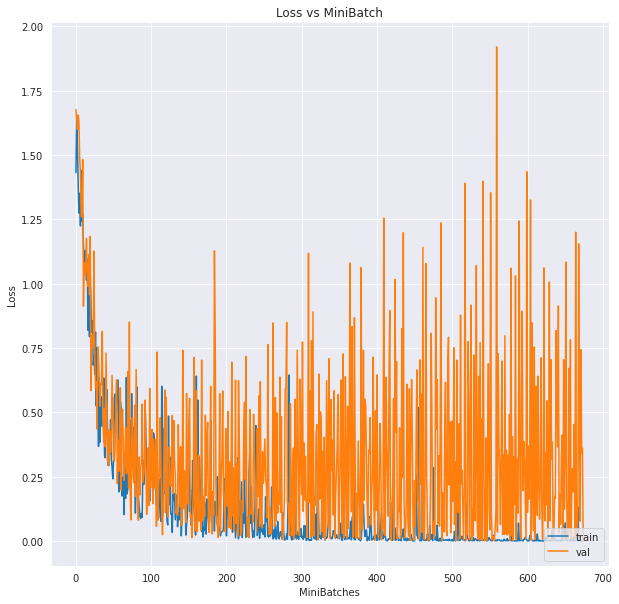

In [14]:
sns.lineplot(x=range(len(loss_history[1])),y=loss_history[0][::len(loss_history[0])//len(loss_history[1])][:len(loss_history[1])])
sns.lineplot(x=range(len(loss_history[1])),y=loss_history[1])

plt.legend(loc='lower right', labels=['train', 'val'])
plt.title("Loss vs MiniBatch")
plt.xlabel('MiniBatches')
plt.ylabel('Loss')


plt.show()


#### 2.Plotting Accuracy vs MiniBatch<a class="anchor" id="5.2"></a>

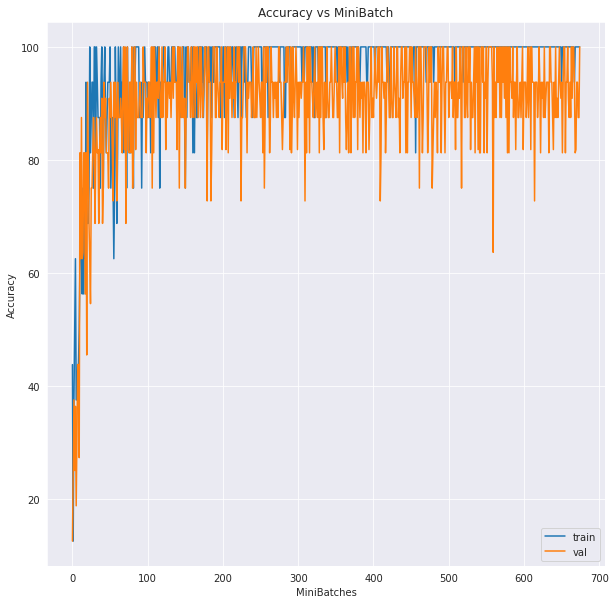

In [15]:
sns.lineplot(x=range(len(accuracy_history[1])),y=accuracy_history[0][::len(accuracy_history[0])//len(accuracy_history[1])][:len(accuracy_history[1])])
sns.lineplot(x=range(len(accuracy_history[1])),y=accuracy_history[1])

plt.legend(loc='lower right', labels=['train', 'val'])
plt.title("Accuracy vs MiniBatch")
plt.xlabel('MiniBatches')
plt.ylabel('Accuracy')

plt.show()


#### 3.Plotting Loss vs Epoch<a class="anchor" id="5.3"></a>

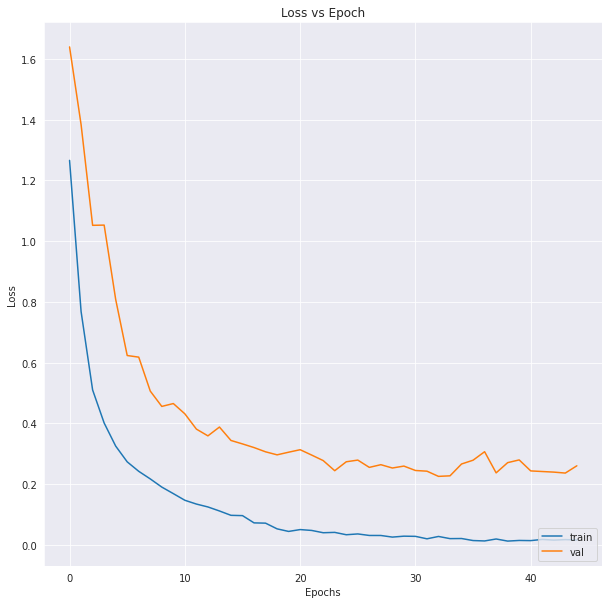

In [16]:
# Plotting Loss per epoch
loss_per_epoch = [[],[]]
for i in range(epoch):
    temp = 0
    for j in loss_history[0][i*train_n_minibatches:(i+1)*train_n_minibatches]:
        temp = temp + j
    loss_per_epoch[0].append(temp/train_n_minibatches)
    temp = 0
    for j in loss_history[1][i*validation_n_minibatches:(i+1)*validation_n_minibatches]:
        temp = temp + j
    loss_per_epoch[1].append(temp/validation_n_minibatches)    

sns.lineplot(x=range(len(loss_per_epoch[0])),y=loss_per_epoch[0])
sns.lineplot(x=range(len(loss_per_epoch[1])),y=loss_per_epoch[1])

plt.legend(loc='lower right', labels=['train', 'val'])
plt.title("Loss vs Epoch")
plt.xlabel('Epochs')
plt.ylabel('Loss')


plt.show()

#### 4.Plotting Accuracy vs Epoch<a class="anchor" id="5.4"></a>

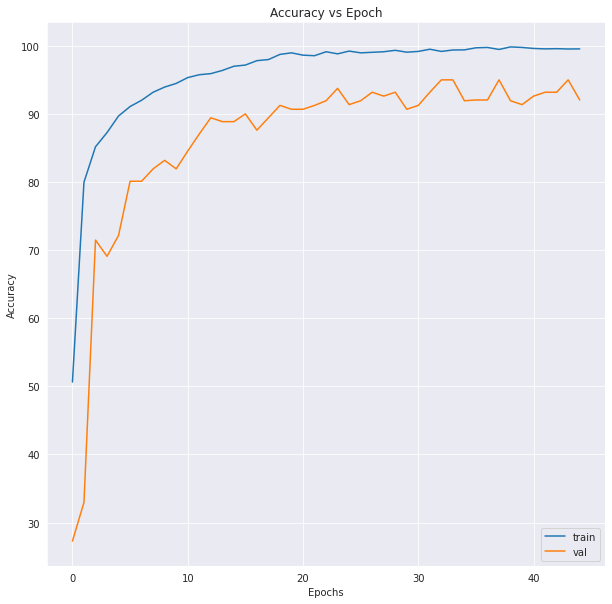

In [17]:
# Plotting Accuracy per epoch
accuracy_per_epoch = [[],[]]
for i in range(epoch):
    temp = 0
    for j in accuracy_history[0][i*train_n_minibatches:(i+1)*train_n_minibatches]:
        temp = temp + j
    accuracy_per_epoch[0].append(temp/train_n_minibatches)
    temp = 0
    for j in accuracy_history[1][i*validation_n_minibatches:(i+1)*validation_n_minibatches]:
        temp = temp + j
    accuracy_per_epoch[1].append(temp/validation_n_minibatches)    

sns.lineplot(x=range(len(accuracy_per_epoch[0])),y=accuracy_per_epoch[0])
sns.lineplot(x=range(len(accuracy_per_epoch[1])),y=accuracy_per_epoch[1])

plt.legend(loc='lower right', labels=['train', 'val'])
plt.title("Accuracy vs Epoch")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.show()

#### 5.Plotting F1Score vs Epoch<a class="anchor" id="5.5"></a>

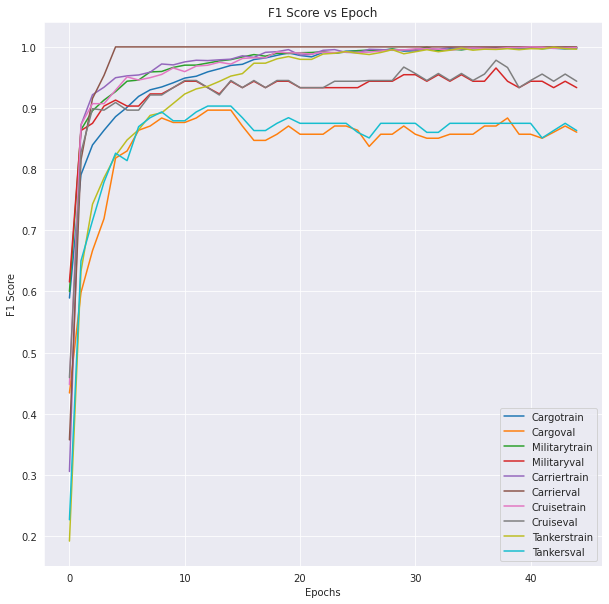

In [18]:
labels = {0:'Cargo',
1:'Military',
2:'Carrier',
3:'Cruise',
4:'Tankers'}

legend = []



for j in range(5):
    sns.lineplot(x=range(len(results[0])),y=[results[0][i][2][j] for i in range(len(results[0]))])
    sns.lineplot(x=range(len(results[1])),y=[results[1][i][2][j] for i in range(len(results[1]))])
    legend+=[labels[j]+'train', labels[j]+'val']



plt.legend(loc='lower right', labels=legend)
plt.title("F1 Score vs Epoch")
plt.xlabel('Epochs')
plt.ylabel('F1 Score')


plt.show()

#### 6.Plotting Recall vs Epoch<a class="anchor" id="5.6"></a>

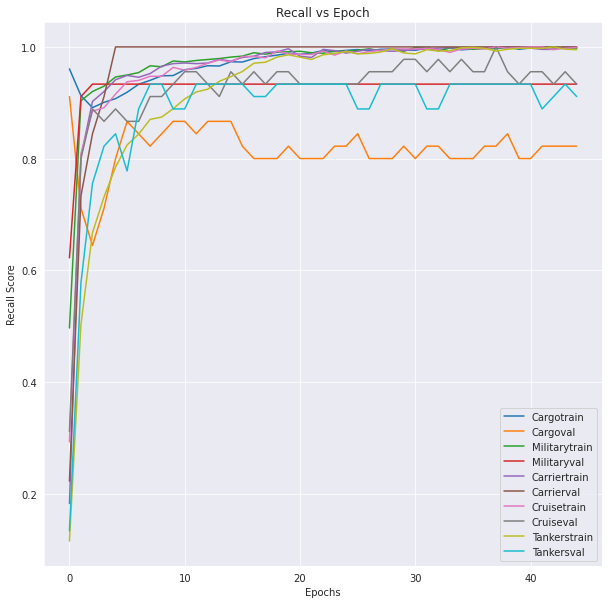

In [19]:
for j in range(5):
    sns.lineplot(x=range(len(results[0])),y=[results[0][i][1][j] for i in range(len(results[0]))])
    sns.lineplot(x=range(len(results[1])),y=[results[1][i][1][j] for i in range(len(results[1]))])


plt.legend(loc='lower right', labels=legend)
plt.title("Recall vs Epoch")
plt.xlabel('Epochs')
plt.ylabel('Recall Score')


plt.show()

#### 7.Plotting Precision vs Epoch<a class="anchor" id="5.7"></a>

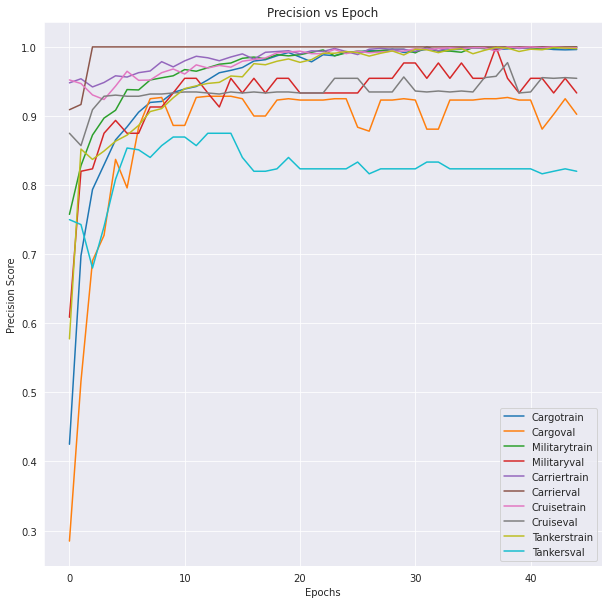

In [20]:
for j in range(5):
    sns.lineplot(x=range(len(results[0])),y=[results[0][i][0][j] for i in range(len(results[0]))])
    sns.lineplot(x=range(len(results[1])),y=[results[1][i][0][j] for i in range(len(results[1]))])


plt.legend(loc='lower right', labels=legend)
plt.title("Precision vs Epoch")
plt.xlabel('Epochs')
plt.ylabel('Precision Score')


plt.show()

#### 8.Plotting Kappa vs Epoch<a class="anchor" id="5.8"></a>

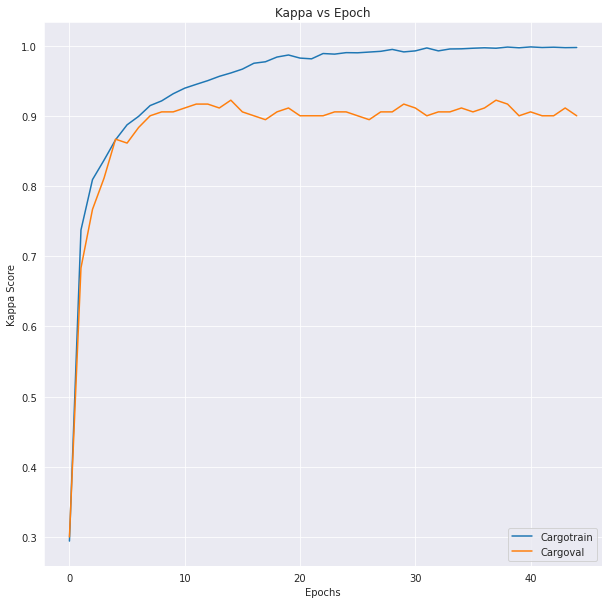

In [21]:

sns.lineplot(x=range(len(kappa[0])),y=kappa[0])
sns.lineplot(x=range(len(kappa[1])),y=kappa[1])


plt.legend(loc='lower right', labels=legend)
plt.title("Kappa vs Epoch")
plt.xlabel('Epochs')
plt.ylabel('Kappa Score')


plt.show()

### 6.Testing <a class="anchor" id="6"></a>

In [22]:
class TestDataset(Dataset):
    def __init__(self,x,transform = 'T.Resize((224,224))'):
        self.transform = transform
        self.x = x
        self.len = len(x)
   
    def __len__(self):
        return self.len
    
    def __getitem__(self,i):
        img = Image.open(self.x[i]).convert('RGB')
        return torch.FloatTensor(np.asarray(self.transform(img)))
    


test_dataset = TestDataset(test_img,transform =transforms_test)
test_dataloader = DataLoader(test_dataset , batch_size = batch_size , shuffle = False )

predictions = []
with torch.no_grad():
    model.eval()
    for _batch_idx_ , x in enumerate(test_dataloader):
        x = x.to(device)
        y_pred = model(x).to(device)
        pred = torch.argmax(y_pred, dim=1)+1
        predictions+=pred.cpu().tolist()

In [23]:
df = pd.DataFrame(list(zip([test_img[i].split('/')[-1] for i in range(len(test_img))], predictions)), index =None, columns =['image', 'category'])
df.to_csv("submission.csv", index=False)
df

,image,category
0,1007700.jpg,4
1,1011369.jpg,4
2,1051155.jpg,4
3,1062001.jpg,2
4,1069397.jpg,4
...,...,...
2675,950995.jpg,4
2676,951046.jpg,4
2677,951323.jpg,4
2678,952113.jpg,4
